In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

PyTorch: 2.8.0+cu126
Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

print(f"Train: {TRAIN_VIDEOS}")
print(f"Test: {TEST_VIDEOS}")
print(f"Train exists: {os.path.exists(TRAIN_VIDEOS)}")
print(f"Test exists: {os.path.exists(TEST_VIDEOS)}")

Train: /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos
Test: /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos
Train exists: True
Test exists: True


In [3]:
CONFIG = {
    # Data
    'image_size': (128, 128),
    'clip_len': 8,              # Number of frames per clip (temporal depth)
    'clip_stride': 4,           # Stride between clips for training
    
    # Model
    'latent_dim': 256,          # Bottleneck size
    'base_channels': 32,        # Starting channels
    
    # Training
    'batch_size': 8,            # Smaller batch due to 3D convs memory
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'patience': 7,
    
    # Ensemble
    'seeds': [42, 123, 456, 789, 1024],  # 5 models for ensemble
    
    # Scoring (our key learnings!)
    'use_max_error': True,      # MAX >> Mean
    'ensemble_method': 'mean',  # Average across models
}

torch.manual_seed(CONFIG['seeds'][0])
np.random.seed(CONFIG['seeds'][0])

print("\nConfiguration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


Configuration:
  image_size: (128, 128)
  clip_len: 8
  clip_stride: 4
  latent_dim: 256
  base_channels: 32
  batch_size: 8
  num_epochs: 30
  learning_rate: 0.0001
  weight_decay: 1e-05
  patience: 7
  seeds: [42, 123, 456, 789, 1024]
  use_max_error: True
  ensemble_method: mean


In [4]:
def discover_frames(video_dir):
    """Discover all frames, handling 'frame_XXXXX.jpg' naming."""
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        print(f"ERROR: {video_dir} not found!")
        return frames
    
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)

total_train = sum(len(v) for v in train_frames.values())
total_test = sum(len(v) for v in test_frames.values())

print(f"Train: {len(train_frames)} videos, {total_train} frames")
print(f"Test: {len(test_frames)} videos, {total_test} frames")

Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames


In [5]:
# Build test frame IDs (needed for submission)
test_frame_ids = []
test_frame_info = []

for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))

print(f"Test frame IDs: {len(test_frame_ids)}")
print(f"Sample: {test_frame_ids[:5]}")

Test frame IDs: 11706
Sample: ['1_939', '1_940', '1_941', '1_942', '1_943']


In [6]:
def load_video_frames_to_gpu(frames_dict, image_size, device):
    """
    Load all frames organized by video.
    Returns dict: {vid: tensor of shape (N, 3, H, W)}
    """
    H, W = image_size
    video_tensors = {}
    video_fnums = {}
    
    total = sum(len(v) for v in frames_dict.values())
    pbar = tqdm(total=total, desc="Loading")
    
    for vid in sorted(frames_dict.keys()):
        n_frames = len(frames_dict[vid])
        tensors = torch.zeros(n_frames, 3, H, W, dtype=torch.float32, device=device)
        fnums = []
        
        for i, (fnum, path) in enumerate(frames_dict[vid]):
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            tensors[i] = torch.from_numpy(arr).permute(2, 0, 1)
            fnums.append(fnum)
            pbar.update(1)
        
        video_tensors[vid] = tensors
        video_fnums[vid] = fnums
    
    pbar.close()
    return video_tensors, video_fnums

print("Loading TRAINING data to GPU...")
train_video_tensors, train_video_fnums = load_video_frames_to_gpu(
    train_frames, CONFIG['image_size'], DEVICE
)
print(f"Loaded {len(train_video_tensors)} training videos")

print("\nLoading TESTING data to GPU...")
test_video_tensors, test_video_fnums = load_video_frames_to_gpu(
    test_frames, CONFIG['image_size'], DEVICE
)
print(f"Loaded {len(test_video_tensors)} testing videos")

print(f"\nGPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading TRAINING data to GPU...


Loading:   0%|          | 0/9204 [00:00<?, ?it/s]

Loaded 16 training videos

Loading TESTING data to GPU...


Loading:   0%|          | 0/11706 [00:00<?, ?it/s]

Loaded 21 testing videos

GPU Memory: 4.12 GB


In [7]:
class VideoClipDataset(Dataset):
    """
    Dataset that returns clips (sequences of frames) for 3D CNN.
    Each clip is (C, T, H, W) where T is clip_len.
    """
    def __init__(self, video_tensors, clip_len, stride, is_train=True):
        self.video_tensors = video_tensors
        self.clip_len = clip_len
        self.clips = []  # List of (vid, start_idx)
        
        for vid, tensors in video_tensors.items():
            n_frames = len(tensors)
            if is_train:
                # Training: use stride to create overlapping clips
                for start in range(0, n_frames - clip_len + 1, stride):
                    self.clips.append((vid, start))
            else:
                # Testing: create all possible clips (stride=1)
                for start in range(0, n_frames - clip_len + 1, 1):
                    self.clips.append((vid, start))
    
    def __len__(self):
        return len(self.clips)
    
    def __getitem__(self, idx):
        vid, start = self.clips[idx]
        # Get clip: (T, C, H, W) -> permute to (C, T, H, W)
        clip = self.video_tensors[vid][start:start + self.clip_len]
        clip = clip.permute(1, 0, 2, 3)  # (C, T, H, W)
        return clip, vid, start

# Create training dataset
train_dataset = VideoClipDataset(
    train_video_tensors, 
    CONFIG['clip_len'], 
    CONFIG['clip_stride'],
    is_train=True
)

print(f"Training clips: {len(train_dataset)}")
print(f"Clip shape: (3, {CONFIG['clip_len']}, {CONFIG['image_size'][0]}, {CONFIG['image_size'][1]})")

Training clips: 2281
Clip shape: (3, 8, 128, 128)


In [8]:
# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,  # Data already on GPU
    pin_memory=False
)

print(f"Training batches: {len(train_loader)}")

# Test batch
sample_clip, sample_vid, sample_start = train_dataset[0]
print(f"Sample clip shape: {sample_clip.shape}")

Training batches: 286
Sample clip shape: torch.Size([3, 8, 128, 128])


In [9]:
class Conv3DBlock(nn.Module):
    """3D Convolution block with BatchNorm and activation."""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm3d(out_ch)
        self.act = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class Deconv3DBlock(nn.Module):
    """3D Transposed Convolution block."""
    def __init__(self, in_ch, out_ch, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.deconv = nn.ConvTranspose3d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm3d(out_ch)
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.act(self.bn(self.deconv(x)))

In [10]:
class Conv3D_Autoencoder(nn.Module):
    """
    3D Convolutional Autoencoder for video anomaly detection.
    
    Input: (B, C, T, H, W) = (batch, 3, 8, 128, 128)
    
    Encoder: Downsample spatially and temporally
    Bottleneck: Tight compression
    Decoder: Upsample back to original size
    
   
    """
    def __init__(self, latent_dim=256, base_ch=32):
        super().__init__()
        
        # Encoder
        # Input: (3, 8, 128, 128)
        self.enc1 = Conv3DBlock(3, base_ch, kernel_size=3, stride=(1,2,2), padding=1)
        # -> (32, 8, 64, 64)
        
        self.enc2 = Conv3DBlock(base_ch, base_ch*2, kernel_size=3, stride=(2,2,2), padding=1)
        # -> (64, 4, 32, 32)
        
        self.enc3 = Conv3DBlock(base_ch*2, base_ch*4, kernel_size=3, stride=(2,2,2), padding=1)
        # -> (128, 2, 16, 16)
        
        self.enc4 = Conv3DBlock(base_ch*4, base_ch*8, kernel_size=3, stride=(2,2,2), padding=1)
        # -> (256, 1, 8, 8)
        
        # Bottleneck
        self.flatten_size = base_ch * 8 * 1 * 8 * 8  # 256 * 64 = 16384
        self.fc_enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, latent_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, self.flatten_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder
        self.dec4 = Deconv3DBlock(base_ch*8, base_ch*4, kernel_size=(2,4,4), stride=(2,2,2), padding=(0,1,1))
        # -> (128, 2, 16, 16)
        
        self.dec3 = Deconv3DBlock(base_ch*4, base_ch*2, kernel_size=4, stride=2, padding=1)
        # -> (64, 4, 32, 32)
        
        self.dec2 = Deconv3DBlock(base_ch*2, base_ch, kernel_size=4, stride=2, padding=1)
        # -> (32, 8, 64, 64)
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose3d(base_ch, 3, kernel_size=(1,4,4), stride=(1,2,2), padding=(0,1,1)),
            nn.Tanh()
        )
        # -> (3, 8, 128, 128)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def encode(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        z = self.fc_enc(x)
        return z
    
    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 256, 1, 8, 8)
        x = self.dec4(x)
        x = self.dec3(x)
        x = self.dec2(x)
        x = self.dec1(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

# Test model
model = Conv3D_Autoencoder(CONFIG['latent_dim'], CONFIG['base_channels']).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(2, 3, 8, 128, 128, device=DEVICE)
    test_output = model(test_input)
    print(f"Forward pass: {test_input.shape} -> {test_output.shape}")
print("✓ Model OK")

Model parameters: 11,275,939
Forward pass: torch.Size([2, 3, 8, 128, 128]) -> torch.Size([2, 3, 8, 128, 128])
✓ Model OK


In [11]:
def train_single_model(seed, train_loader, config, device):
    """Train a single 3D CNN model with given seed."""
    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Create model
    model = Conv3D_Autoencoder(config['latent_dim'], config['base_channels']).to(device)
    
    # Optimizer and loss
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.MSELoss()
    
    # Training loop
    best_loss = float('inf')
    patience_counter = 0
    best_state = None
    
    for epoch in range(config['num_epochs']):
        model.train()
        epoch_loss = 0
        
        for batch_clips, _, _ in train_loader:
            # batch_clips already on GPU, shape: (B, C, T, H, W)
            optimizer.zero_grad(set_to_none=True)
            
            recon = model(batch_clips)
            loss = criterion(recon, batch_clips)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        # Early stopping
        if avg_loss < best_loss - 1e-5:
            best_loss = avg_loss
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1}: loss={avg_loss:.6f}, best={best_loss:.6f}")
        
        if patience_counter >= config['patience']:
            print(f"    Early stopping at epoch {epoch+1}")
            break
    
    # Load best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    
    return model, best_loss

In [12]:
print("=" * 60)
print("TRAINING 3D CNN ENSEMBLE")
print("=" * 60)
print(f"Training {len(CONFIG['seeds'])} models...")

models = []
losses = []

for i, seed in enumerate(CONFIG['seeds']):
    print(f"\nModel {i+1}/{len(CONFIG['seeds'])} (seed={seed})")
    start_time = time.time()
    
    model, loss = train_single_model(seed, train_loader, CONFIG, DEVICE)
    models.append(model)
    losses.append(loss)
    
    elapsed = time.time() - start_time
    print(f"    Best loss: {loss:.6f}, Time: {elapsed/60:.1f} min")

print("\n" + "=" * 60)
print(f"Ensemble training complete!")
print(f"Losses: {[f'{l:.5f}' for l in losses]}")
print("=" * 60)

TRAINING 3D CNN ENSEMBLE
Training 5 models...

Model 1/5 (seed=42)
    Epoch 5: loss=0.007313, best=0.007313
    Epoch 10: loss=0.004570, best=0.004570
    Epoch 15: loss=0.003611, best=0.003611
    Epoch 20: loss=0.003019, best=0.003019
    Epoch 25: loss=0.002594, best=0.002594
    Epoch 30: loss=0.002354, best=0.002354
    Best loss: 0.002354, Time: 7.3 min

Model 2/5 (seed=123)
    Epoch 5: loss=0.007635, best=0.007635
    Epoch 10: loss=0.004692, best=0.004692
    Epoch 15: loss=0.003618, best=0.003618
    Epoch 20: loss=0.003006, best=0.003006
    Epoch 25: loss=0.002628, best=0.002628
    Epoch 30: loss=0.002345, best=0.002345
    Best loss: 0.002345, Time: 7.3 min

Model 3/5 (seed=456)
    Epoch 5: loss=0.007187, best=0.007187
    Epoch 10: loss=0.004652, best=0.004652
    Epoch 15: loss=0.003638, best=0.003638
    Epoch 20: loss=0.003085, best=0.003085
    Epoch 25: loss=0.002631, best=0.002631
    Epoch 30: loss=0.002401, best=0.002401
    Best loss: 0.002401, Time: 7.3 min



In [13]:
@torch.no_grad()
def compute_clip_scores(model, video_tensors, video_fnums, clip_len, device):
    """
    Compute reconstruction error for all frames.
    For each frame, compute MAX error across all clips containing it.
    """
    model.eval()
    
    # Store errors for each frame
    frame_errors = defaultdict(list)  # {(vid, fnum): [error1, error2, ...]}
    
    for vid, tensors in tqdm(video_tensors.items(), desc="Scoring"):
        fnums = video_fnums[vid]
        n_frames = len(tensors)
        
        if n_frames < clip_len:
            # Video too short, score each frame individually
            for i, fnum in enumerate(fnums):
                frame_errors[(vid, fnum)].append(0.0)
            continue
        
        # Process all clips in this video
        for start in range(n_frames - clip_len + 1):
            # Get clip
            clip = tensors[start:start + clip_len].permute(1, 0, 2, 3)  # (C, T, H, W)
            clip = clip.unsqueeze(0)  # (1, C, T, H, W)
            
            # Reconstruct
            recon = model(clip)
            
            # Compute per-frame MAX error within this clip
            # clip and recon: (1, C, T, H, W)
            pixel_err = (clip - recon) ** 2  # (1, C, T, H, W)
            
            # MAX error per frame in clip (max over C, H, W)
            frame_max_err = torch.amax(pixel_err, dim=(1, 3, 4))  # (1, T)
            frame_max_err = frame_max_err.squeeze(0).cpu().numpy()  # (T,)
            
            # Assign to frames
            for t in range(clip_len):
                fnum = fnums[start + t]
                frame_errors[(vid, fnum)].append(float(frame_max_err[t]))
    
    # Aggregate: take MAX error across all clips containing each frame
    scores = {}
    for (vid, fnum), errors in frame_errors.items():
        if errors:
            scores[f"{vid}_{fnum}"] = max(errors)  # MAX across clips
        else:
            scores[f"{vid}_{fnum}"] = 0.0
    
    return scores

In [14]:
print("Computing scores from all models...")

all_model_scores = []

for i, model in enumerate(models):
    print(f"\nModel {i+1}/{len(models)}...")
    scores = compute_clip_scores(
        model, test_video_tensors, test_video_fnums, 
        CONFIG['clip_len'], DEVICE
    )
    all_model_scores.append(scores)
    print(f"  Scored {len(scores)} frames")

# Verify coverage
expected = set(test_frame_ids)
for i, scores in enumerate(all_model_scores):
    missing = expected - set(scores.keys())
    print(f"Model {i+1}: {len(scores)} scores, {len(missing)} missing")

Computing scores from all models...

Model 1/5...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Scored 11706 frames

Model 2/5...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Scored 11706 frames

Model 3/5...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Scored 11706 frames

Model 4/5...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Scored 11706 frames

Model 5/5...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Scored 11706 frames
Model 1: 11706 scores, 0 missing
Model 2: 11706 scores, 0 missing
Model 3: 11706 scores, 0 missing
Model 4: 11706 scores, 0 missing
Model 5: 11706 scores, 0 missing


In [16]:
# Handle missing frames (frames at video boundaries)
# For missing frames, use score from nearest available frame

def fill_missing_scores(scores, test_frames, video_fnums):
    """Fill missing scores with nearest neighbor."""
    filled = scores.copy()
    
    for vid in sorted(test_frames.keys()):
        fnums = video_fnums[vid]
        
        for fnum in fnums:
            fid = f"{vid}_{fnum}"
            if fid not in filled or filled[fid] == 0.0:
                # Find nearest scored frame
                best_dist = float('inf')
                best_score = 0.0
                
                for other_fnum in fnums:
                    other_fid = f"{vid}_{other_fnum}"
                    if other_fid in scores and scores[other_fid] > 0:
                        dist = abs(fnum - other_fnum)
                        if dist < best_dist:
                            best_dist = dist
                            best_score = scores[other_fid]
                
                filled[fid] = best_score
    
    return filled

# Fill missing for all models
all_model_scores_filled = []
for scores in all_model_scores:
    filled = fill_missing_scores(scores, test_frames, test_video_fnums)
    all_model_scores_filled.append(filled)
    
print(f"Filled missing scores")
print(f"Coverage: {len(all_model_scores_filled[0])}/{len(test_frame_ids)}")

Filled missing scores
Coverage: 11706/11706


In [17]:
def normalize_scores(scores, clip_pct=99):
    """Normalize scores to [0, 1] with outlier clipping."""
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    
    v_min, v_max = vals.min(), vals.max()
    if v_max - v_min > 1e-8:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    
    return {k: float(norm[i]) for i, k in enumerate(keys)}

def ensemble_mean(score_list):
    """Average scores across models."""
    keys = list(score_list[0].keys())
    return {k: np.mean([s[k] for s in score_list]) for k in keys}

def ensemble_median(score_list):
    """Median scores across models."""
    keys = list(score_list[0].keys())
    return {k: np.median([s[k] for s in score_list]) for k in keys}

# Normalize individual model scores
all_norm_scores = [normalize_scores(s) for s in all_model_scores_filled]

# Create ensembles
ensembles = {}

# All 5 models
ensembles['3dcnn_avg_all5'] = normalize_scores(ensemble_mean(all_norm_scores), clip_pct=100)
ensembles['3dcnn_median_all5'] = normalize_scores(ensemble_median(all_norm_scores), clip_pct=100)

# 3-model subsets
ensembles['3dcnn_avg_3_v1'] = normalize_scores(ensemble_mean(all_norm_scores[:3]), clip_pct=100)
ensembles['3dcnn_avg_3_v2'] = normalize_scores(ensemble_mean(all_norm_scores[1:4]), clip_pct=100)
ensembles['3dcnn_avg_3_v3'] = normalize_scores(ensemble_mean(all_norm_scores[2:5]), clip_pct=100)

# Individual models
for i, scores in enumerate(all_norm_scores):
    ensembles[f'3dcnn_single_{i+1}'] = scores

print(f"Created {len(ensembles)} submission variants")

Created 10 submission variants


In [18]:
def save_submission(scores, filename):
    """Save submission CSV."""
    data = [{'Id': fid, 'Predicted': scores.get(fid, 0.0)} for fid in test_frame_ids]
    df = pd.DataFrame(data)
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=False)
    
    # Verify
    assert len(df) == len(test_frame_ids), "Row count mismatch!"
    assert df['Predicted'].isna().sum() == 0, "NaN values!"
    
    print(f"Saved: {filename} ({len(df)} rows)")
    return df

print("Generating submissions...")
print("-" * 40)

submissions = {}
for name, scores in ensembles.items():
    submissions[name] = save_submission(scores, f'sub_{name}.csv')

print("-" * 40)
print(f"Generated {len(submissions)} submissions")

Generating submissions...
----------------------------------------
Saved: sub_3dcnn_avg_all5.csv (11706 rows)
Saved: sub_3dcnn_median_all5.csv (11706 rows)
Saved: sub_3dcnn_avg_3_v1.csv (11706 rows)
Saved: sub_3dcnn_avg_3_v2.csv (11706 rows)
Saved: sub_3dcnn_avg_3_v3.csv (11706 rows)
Saved: sub_3dcnn_single_1.csv (11706 rows)
Saved: sub_3dcnn_single_2.csv (11706 rows)
Saved: sub_3dcnn_single_3.csv (11706 rows)
Saved: sub_3dcnn_single_4.csv (11706 rows)
Saved: sub_3dcnn_single_5.csv (11706 rows)
----------------------------------------
Generated 10 submissions


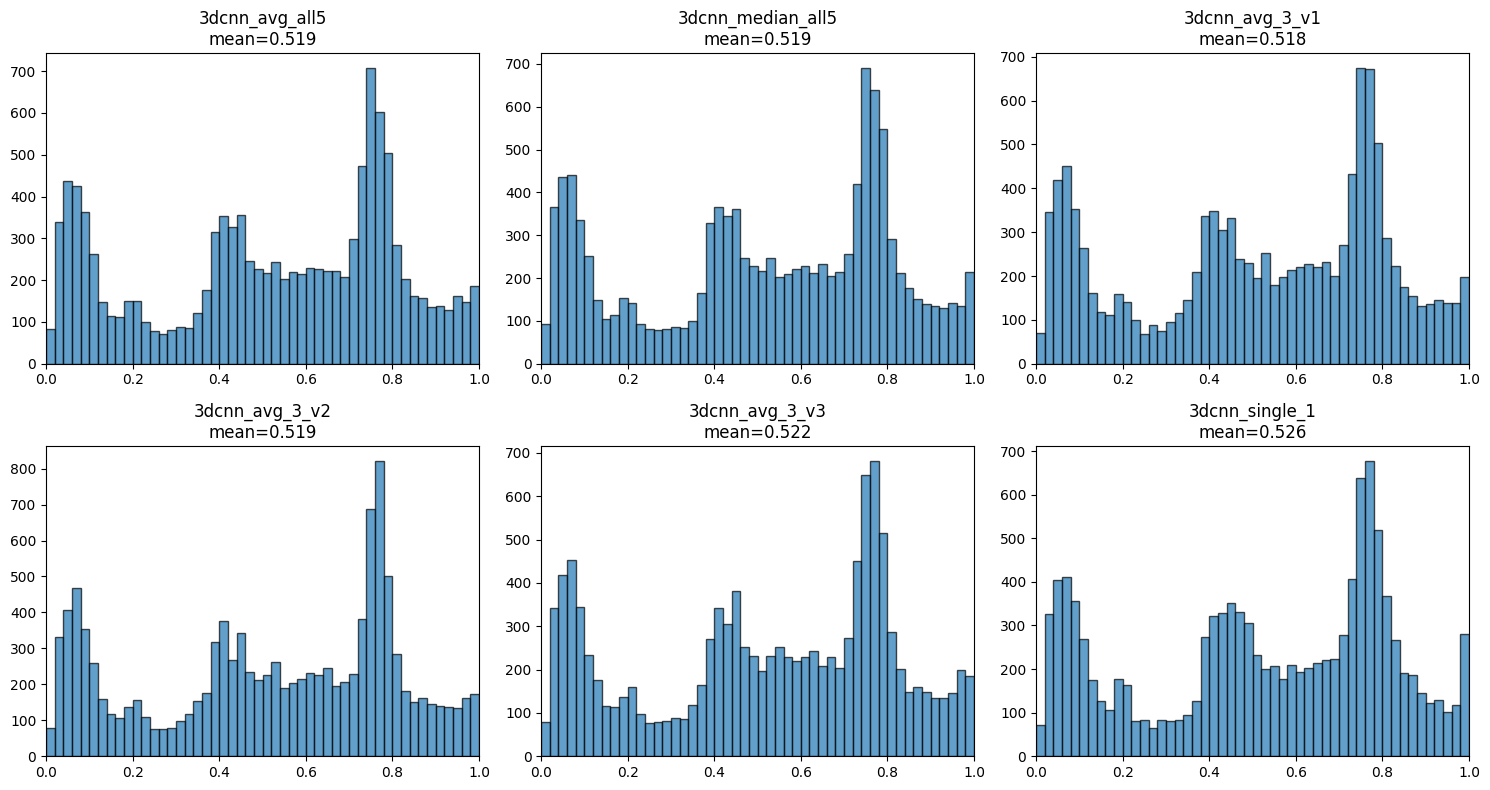

In [19]:
# Score distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, (name, scores) in enumerate(list(ensembles.items())[:6]):
    ax = axes[idx // 3, idx % 3]
    vals = list(scores.values())
    ax.hist(vals, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name}\nmean={np.mean(vals):.3f}')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'score_distributions.png'))
plt.show()

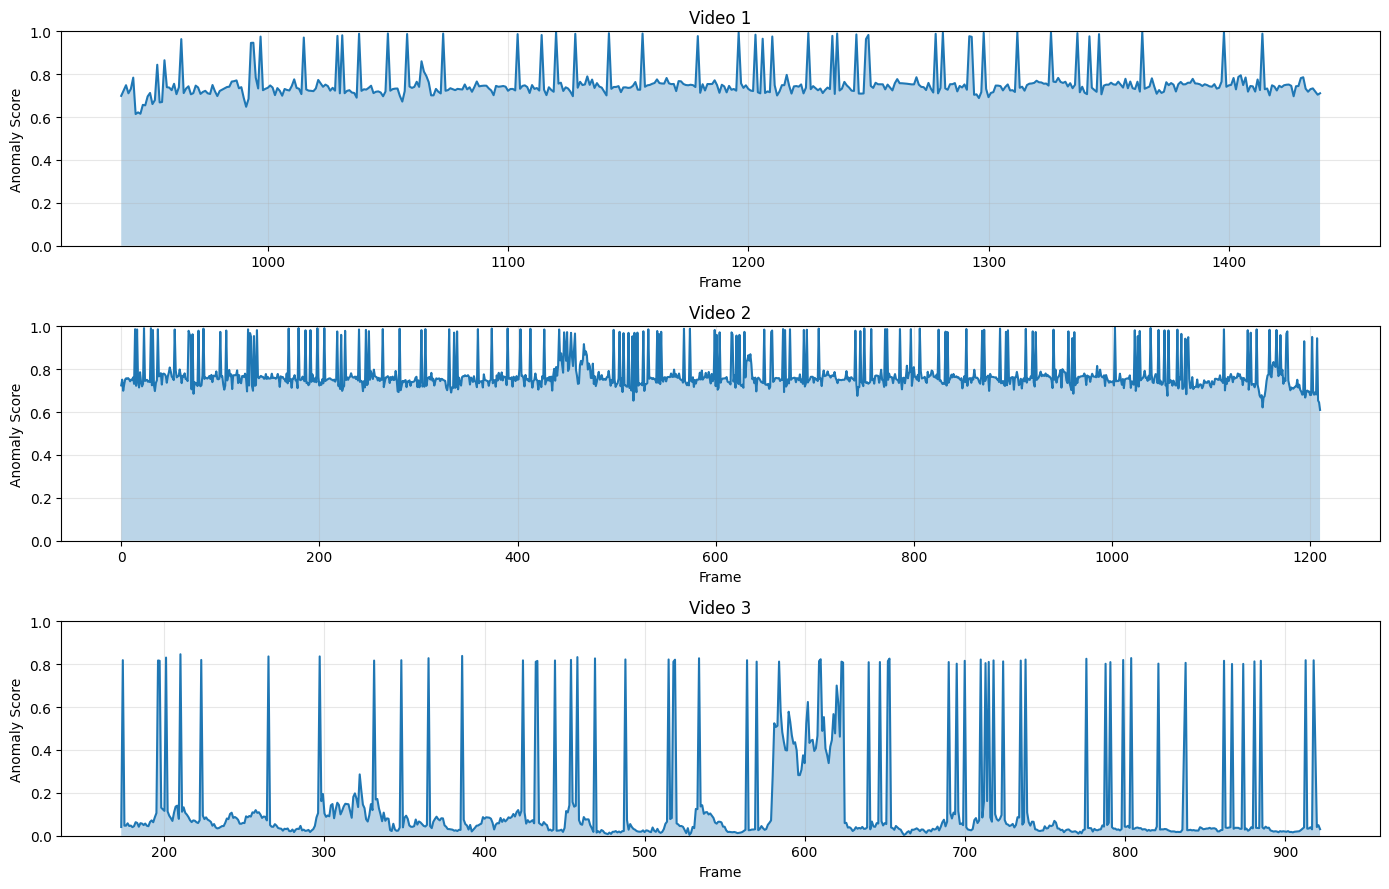

In [20]:
# Temporal visualization for sample videos
n_vids = min(3, len(test_video_tensors))
fig, axes = plt.subplots(n_vids, 1, figsize=(14, 3*n_vids))
if n_vids == 1:
    axes = [axes]

for idx, vid in enumerate(sorted(test_video_tensors.keys())[:n_vids]):
    fnums = test_video_fnums[vid]
    
    # Get scores from best ensemble
    scores = [ensembles['3dcnn_avg_all5'].get(f"{vid}_{fn}", 0) for fn in fnums]
    
    axes[idx].plot(fnums, scores, linewidth=1.5)
    axes[idx].fill_between(fnums, scores, alpha=0.3)
    axes[idx].set_title(f'Video {vid}')
    axes[idx].set_xlabel('Frame')
    axes[idx].set_ylabel('Anomaly Score')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_scores.png'))
plt.show()